# Rees analysis
---

**Associated references: Brasington et al. (2012), Williams et al.(2013b) and Marco Redolfi's thesis.**

This notebook contains the analysis of the relationship between the morphological active width (MAW) and the t/Txnr ratio at the Pinzano site along the Tagliamento river. Some other relationships with the exner timescale are investigated.
The methodology is as follow:
1. Estimate relationship between water discharge, depth and sediment flux from cross-sections and uniform flow model
1. Import the water depth measurements from the gauging station
2. Average the water depth every hour
3. Calculate Q from the water depth and Qs, Wetted width, Water depth, Txnr, t/Txnr and dimensionless streamm power w* every hour.
4. Detecting flood from the water discharge time serie based on a critical discharge Qc (Q>Qc are considered floods)
5. Import survey time period and for each compute the mean_Q_above_Qc, max_Q_above_Qc, mean_Ww_above_Qc, max_Ww_above_Qc, sum_t_Txnr_above_Qc, mean_w*_above_Qc, max_w*_above_Qc.
6. Compute DoDs envelops
7. Compute the MAW as follow:
$$
\frac{Area\; of\; morphological\; changes}{Reach\; length\; *\; Max\; wetted\; width}
$$ for the survey time period.

**Some information:**
* Data collected between October 2009 and May 2010
* 10 storms
* DEM resolution : 0.5 m
* Water level data every 15min from September 2009 to March 2011 at a gauging station located 1 km downstrea the confluence between Invincible creek and the Rees river (single channel confined)
* Qcr = 30 m3/s

In [2]:
import os
import math
import rasterio 
import numpy as np
import pandas as pd
import math
from osgeo import gdal
from osgeo import osr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
home_folder = os.getcwd()

In [8]:
# functions
# Function to read the tif file and return the 2D array
def read_tif(file_path):
    with rasterio.open(file_path) as src:
        array = src.read(1)  # Read the first band
    return array

GDAL_DATA_TYPE = gdal.GDT_Float32 
GEOTIFF_DRIVER_NAME = r'GTiff'
def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):
    ''' returns gdal data source raster object

    '''
    # create driver
    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path,
                                  int(columns),
                                  int(rows),
                                  nband,
                                  eType = gdal_data_type)    
    return output_raster


def numpy_array_to_raster(output_path,
                          numpy_array,
                          upper_left_tuple,
                          cell_resolution_x,  # Resolution in x-direction
                          cell_resolution_y,  # Resolution in y-direction
                          no_data=0,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=4326,  # Default to WGS84
                          driver='GTiff'):
    ''' Returns a GDAL raster data source from a 2D or 3D NumPy array.

    Keyword arguments:
    - output_path -- Full path to the raster to be written to disk.
    - numpy_array -- NumPy array containing data to write to raster.
                     2D array for single-band, 3D array for multi-band.
    - upper_left_tuple -- Upper left point of the numpy array (structured as (x, y)).
    - cell_resolution_x -- The cell resolution of the output raster in x-direction.
    - cell_resolution_y -- The cell resolution of the output raster in y-direction.
    - no_data -- Value in numpy array that should be treated as no data.
    - gdal_data_type -- GDAL data type of raster (see GDAL documentation for list of values).
    - spatial_reference_system_wkid -- Well Known ID (WKID) of the spatial reference system.
    - driver -- String value of the GDAL driver to use (e.g., 'GTiff' for GeoTIFF).

    Returns:
    - output_raster -- The created GDAL raster object.
    '''

    # Check if the input numpy array is 2D or 3D
    if len(numpy_array.shape) == 2:  # Single-band image
        rows, columns = numpy_array.shape
        bands = 1
    elif len(numpy_array.shape) == 3:  # Multi-band image
        rows, columns, bands = numpy_array.shape
    else:
        raise ValueError("Unsupported array shape: should be 2D (single-band) or 3D (multi-band).")

    print(f'Array Shape: Rows = {rows}, Columns = {columns}, Bands = {bands}')

    # Create the output raster with the specified driver
    gdal_driver = gdal.GetDriverByName(driver)
    output_raster = gdal_driver.Create(output_path, columns, rows, bands, gdal_data_type)

    if output_raster is None:
        raise Exception(f"Failed to create raster: {output_path}")

    # Set geotransform (upper-left corner, pixel resolution in x and y, and other parameters)
    geotransform = (upper_left_tuple[0],  # x-coordinate of the upper-left corner
                    cell_resolution_x,    # pixel width (x-resolution)
                    0,                    # rotation (0 if image is north-up)
                    upper_left_tuple[1],  # y-coordinate of the upper-left corner
                    0,                    # rotation (0 if image is north-up)
                    -cell_resolution_y)   # pixel height (y-resolution, negative for north-up)

    output_raster.SetGeoTransform(geotransform)

    # Define the spatial reference system
    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromEPSG(spatial_reference_system_wkid)
    output_raster.SetProjection(spatial_reference.ExportToWkt())

    # Write each band (for multi-band images, or just one band for single-band)
    for band in range(bands):
        output_band = output_raster.GetRasterBand(band + 1)  # Bands are 1-based in GDAL
        output_band.SetNoDataValue(no_data)
        if bands == 1:
            # Single-band raster
            output_band.WriteArray(numpy_array)
        else:
            # Multi-band raster, write each band
            output_band.WriteArray(numpy_array[:, :, band])
        output_band.FlushCache()
        output_band.ComputeStatistics(True)

    # Ensure the file was created
    if not os.path.exists(output_path):
        raise Exception(f'Failed to create raster: {output_path}')
    
    print(f"Raster successfully created at {output_path}")

    return output_raster



def power_law_model(x, a, b):
    return a * (x ** b)

def logarithmic_model(x, a, b):
    return a * np.log(x) + b

def compute_r_squared(y_true, y_pred):
    """
    Compute the coefficient of determination (R-squared).

    Parameters:
        y_true (array-like): Observed values.
        y_pred (array-like): Predicted values.

    Returns:
        float: R-squared value.
    """
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def fit_and_evaluate_models(x, y):
    """
    Fit power law and logarithmic models to the data, compute R-squared, and return results.

    Parameters:
        x (array-like): Independent variable.
        y (array-like): Dependent variable.

    Returns:
        dict: Model parameters and R-squared values.
    """
    results = {}

    # Power Law Model
    popt_power, _ = curve_fit(power_law_model, x, y, maxfev=10000)
    y_pred_power = power_law_model(x, *popt_power)
    r_squared_power = compute_r_squared(y, y_pred_power)
    results['Power Law'] = {'parameters': popt_power, 'r_squared': r_squared_power}

    # Logarithmic Model
    popt_log, _ = curve_fit(logarithmic_model, x, y, maxfev=10000)
    y_pred_log = logarithmic_model(x, *popt_log)
    r_squared_log = compute_r_squared(y, y_pred_log)
    results['Logarithmic'] = {'parameters': popt_log, 'r_squared': r_squared_log}

    return results


def linear_regression(x, y):
    """
    Perform a simple linear regression on two arrays, x and y.

    Parameters:
        x (array-like): Independent variable.
        y (array-like): Dependent variable.

    Returns:
        tuple: Slope and intercept of the best-fit line (m, b).
    """
    # Convert inputs to numpy arrays for easy manipulation
    x = np.array(x)
    y = np.array(y)

    # Calculate the means of x and y
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the slope (m)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    m = numerator / denominator

    # Calculate the intercept (b)
    b = y_mean - m * x_mean

    return m, b

## Estimate relationship between water discharge, depth and sediment flux

### Estimate Q-Ww and Q-H from graphflood simulations (not used)

This section presents results from Graphflood hydraulic simulations. The aim is to estimate the relationships between Q, the wetted width and the water depth. The investigated water discharges are: 24, 50, 100, 150, 200, 250, 300, 350, 400, 450, and 500 m3/s.

In [9]:
path = os.path.join(home_folder, 'Data', 'Water_depth_maps')
discharges = [24, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
h_threshold = 0.1 # in meter
mask_name = 'simulation_area_mask.tif'
mask_total_area = read_tif(os.path.join(path,mask_name))
total_area = len(mask_total_area[mask_total_area==1])
reach_length = 2574 # meter
mean_wetted_width = []
mean_water_depth= []
for i, Qw in enumerate(discharges):
    filename = f'water_depth_Q{Qw}.tif'
    water_depth = read_tif(os.path.join(path,filename))
    water_depth = np.where(water_depth<h_threshold, np.nan, water_depth)
    wetted_width = len(water_depth[water_depth>=h_threshold])/reach_length # meter

    mean_water_depth = np.append(mean_water_depth, np.nanmean(water_depth))
    mean_wetted_width = np.append(mean_wetted_width, wetted_width)

# fits
results = fit_and_evaluate_models(discharges, mean_wetted_width)
for model, data in results.items():
    print(f"{model} Model:")
    print(f"  Parameters: {data['parameters']}")
    print(f"  R-squared: {data['r_squared']:.4f}")
    if model == 'Power Law':
        a = data['parameters'][0]
        b = data['parameters'][1]

wetted_width_pred = a * discharges ** b
slope, intercept = linear_regression(discharges, mean_water_depth)
print(f'slope: {slope}, intercept: {intercept}')
water_depth_pred = [slope * xi + intercept for xi in discharges]

Power Law Model:
  Parameters: [28.09386047  0.45482062]
  R-squared: 0.9581
Logarithmic Model:
  Parameters: [ 128.15460911 -344.80788324]
  R-squared: 0.9886
slope: 0.0007195606069199373, intercept: 0.3098268719165368


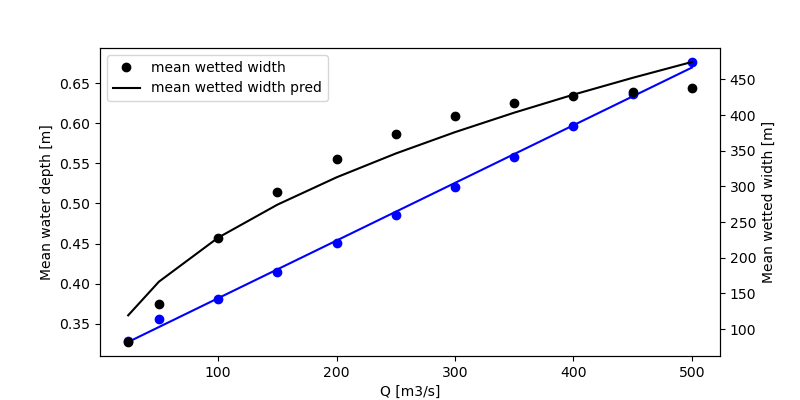

In [10]:
%matplotlib widget
fig, ax1 = plt.subplots(1,1,figsize=(8,4)) # creating my fig
ax1.plot(discharges, mean_water_depth, 'bo', label='mean water depth')
ax1.plot(discharges, water_depth_pred, 'b-', label='water depth pred')
#ax1.set_xlim(0,250)
#ax1.set_ylim(0,450)
ax1.set_xlabel('Q [m3/s]')
ax1.set_ylabel('Mean water depth [m]')
ax2 = ax1.twinx()
ax2.plot(discharges, mean_wetted_width, 'ko', label = 'mean wetted width')
ax2.plot(discharges, wetted_width_pred, 'k-', label='mean wetted width pred')
ax2.set_ylabel('Mean wetted width [m]')
plt.legend()

### From the uniform flow model

In the end, the relationships of the wetted width, the water depth and the sediment flux with the water discharge is estimated from a uniform flow model applied on cross-sections (see Q-Qs_Q-Ww_curves.csv file). In total, there are 10 cross-sections spaced of 200 m to each other (see prepare_uniform_flow_model.py file). The model has been applied on the e00 DEM. 

In [11]:
# Qs = a*Q**b
a = 1e-5
b = 1.61 

# Ww = c*Q**d # to correct 
#c = 22 
#d = 0.49
#from simulations
c = 28.1
d = 0.45
# uniform model
#a = 1e-4
#b = 1.33
#c = 21
#d = 0.53
e = 0.0008#0.00072 # mean depth eQ+b
f = 0.21#0.31
porosity = 0.25

## Import water discharge dataset and average Q every hour

In [12]:
path = os.path.join(home_folder,'Data')
df_hydro = pd.read_csv(os.path.join(path,'Hydrograph.txt'), delimiter ='\t')
df_hydro['t [days]'] = df_hydro['t [min]']/60/24

# 1. Average Q every hour
window_size = 4 # 1h

# Create a list to store the rolling mean values
rolling_mean_values = []

# Iterate over the DataFrame
for i in range(len(df_hydro)):
    # Calculate rolling mean for the current row
    if i + 1 >= window_size:
        # Get the window of values based on the dynamic window size
        window = df_hydro['Q [m3/s]'][i + 1 - window_size:i + 1]
        rolling_mean = window.mean()
    else:
        # Not enough data points for the window, so set NaN
        rolling_mean = np.nan

    # Append the calculated mean to the list
    rolling_mean_values.append(rolling_mean)

# Add the rolling mean values as a new column
df_hydro['smoothed Q [m3/s]'] = rolling_mean_values
df_hydro = df_hydro.fillna(0)

## Calculate Q, Qs, Ww, Water depth, Txnr, t/Txnr and, w*

In [13]:
# 2. compute hydraulics
# estimate Qs
df_hydro['Qs [m3/s]'] = a*df_hydro['smoothed Q [m3/s]']**b
# estimate Wetted width
df_hydro['Ww [m]'] = c*df_hydro['smoothed Q [m3/s]']**d

# estimate mean water depth
# H (m)
ks = 40
slope = 0.00574
df_hydro['hw [m]'] = e*df_hydro['smoothed Q [m3/s]']+f## (df_hydro['smoothed Q [m3/s]']/df_hydro['Ww [m]']/ks/math.sqrt(slope))**0.6 

#3. Compute t_Txnr
def calculate_t_Txnr(row):
    porosity = 0.25
    time_step = 15 #min 
    
    # Access the columns
    depth = row['hw [m]']
    wetted_width = row['Ww [m]']
    Q = row['smoothed Q [m3/s]']
    Qs = row['Qs [m3/s]']

    if depth == 0:
        t_txnr = 0
    else:
        t_txnr = (time_step*60)/((1-porosity)*((depth*(wetted_width**2))/Qs))
    
    return t_txnr
    
def calculate_Txnr(row):
    #porosity = 0.20
    
    # Access the columns
    depth = row['hw [m]']
    wetted_width = row['Ww [m]']
    Q = row['smoothed Q [m3/s]']
    Qs = row['Qs [m3/s]']

    if depth == 0:
        txnr = 0
    else:
        txnr = ((1-porosity)*((depth*(wetted_width**2))/Qs))/3600 # in hours
    
    return txnr
df_hydro['t_Txnr'] = df_hydro.apply(calculate_t_Txnr, axis=1) # df survey
df_hydro['Txnr [h]']= df_hydro.apply(calculate_Txnr, axis=1)

# 4. Compute adim stream power
def calculate_adim_stream_power(row):
    # Access the columns
    Q = row['smoothed Q [m3/s]']
    wetted_width = row['Ww [m]']
    d50 = 0.0199
    slope = 0.00574

    if Q== 0:
        adim_w = 0
    else:
        adim_w = (Q*slope)/(wetted_width*math.sqrt(9.81*1.65*d50**3))
    
    return adim_w
    
df_hydro['w*']= df_hydro.apply(calculate_adim_stream_power, axis=1)

C:\Users\thoma\AppData\Local\Temp\ipykernel_89108\2605502357.py:27: RuntimeWarning: invalid value encountered in scalar divide
  t_txnr = (time_step*60)/((1-porosity)*((depth*(wetted_width**2))/Qs))
C:\Users\thoma\AppData\Local\Temp\ipykernel_89108\2605502357.py:43: RuntimeWarning: invalid value encountered in scalar divide
  txnr = ((1-porosity)*((depth*(wetted_width**2))/Qs))/3600 # in hours


## Import survey time periods and set an id for each survey

In [14]:
#5. Set id as unpair number for survey time and pair number between surveys
df_survey = pd.read_csv(os.path.join(path,'Survey_times.txt'), delimiter ='\t')

# set id for each survey duration
df_hydro['surveys_id'] = df_hydro['t [min]']*0 # initialize
survey_name_list = [1,3,5,7,9,11,13,15] # id = survey name + 1 (unpaired)
Q_surveys = []
time_surveys = []
t_Txnr_surveys = []
adim_stream_power_surveys = []
for i, survey in enumerate(survey_name_list):
    start = df_survey.iloc[i,1]
    end = df_survey.iloc[i,2]
    df_hydro.iloc[start-1:end-1, 11] = df_hydro.iloc[start-1:end-1, 11]*0 + survey
    Q_surveys.append(df_hydro.iloc[start-1:end-1, 4]) # index 2 is smoothed discharge Q
    time_surveys.append(df_hydro.iloc[start-1:end-1, 3]) # index 3 is t [days]
    t_Txnr_surveys.append(df_hydro.iloc[start-1:end-1, 8]) # index 8 is t_Txnr
    adim_stream_power_surveys.append(df_hydro.iloc[start-1:end-1, 10])  # index 10 is w*
    
periods_without_survey_ids = [0,2,4,6,8,10,12,14,16,18] # (paired)
count_row = 0
count_block = 0
for i in range(0,len(df_hydro)):
    if df_hydro.iloc[i,11] == 0: #surveys_id
        df_hydro.iloc[i,11] = periods_without_survey_ids[count_block]
        count_row = count_row +1 
    else:
        if count_row > 0:
            count_block = count_block + 1
            count_row = 0
        else:
            pass

In [15]:
df_hydro

,t [min],h [mm],Q [m3/s],t [days],smoothed Q [m3/s],Qs [m3/s],Ww [m],hw [m],t_Txnr,Txnr [h],w*,surveys_id
0,0,717,19.30000,0.000000,0.00000,0.000000,0.000000,0.210000,NaN,NaN,0.000000,0
1,15,710,18.90000,0.010417,0.00000,0.000000,0.000000,0.210000,NaN,NaN,0.000000,0
2,30,704,18.70000,0.020833,0.00000,0.000000,0.000000,0.210000,NaN,NaN,0.000000,0
3,45,704,18.70000,0.031250,18.90000,0.001135,105.466402,0.225120,0.000544,459.512787,0.091076,0
4,60,699,18.40000,0.041667,18.67500,0.001114,104.899543,0.224940,0.000540,463.066176,0.090478,0
...,...,...,...,...,...,...,...,...,...,...,...,...
53068,796020,289,8.79524,552.791667,8.64110,0.000322,74.158747,0.216913,0.000324,771.778598,0.059219,16
53069,796035,285,8.67140,552.802083,8.66411,0.000323,74.247545,0.216931,0.000325,770.388139,0.059306,16
53070,796050,285,8.67140,552.812500,8.66411,0.000323,74.247545,0.216931,0.000325,770.388139,0.059306,16
53071,796065,283,8.60996,552.822917,8.68700,0.000325,74.335752,0.216950,0.000325,769.011232,0.059392,16


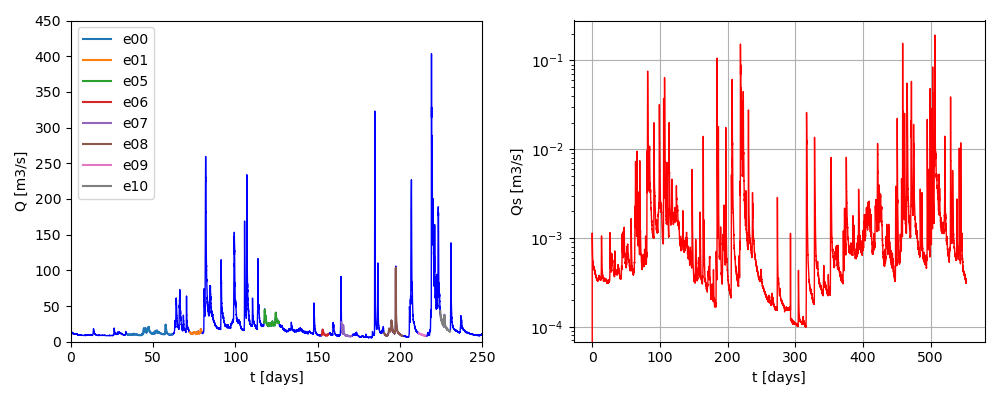

In [16]:
%matplotlib widget
survey_names = ['e00','e01','e05','e06','e07','e08','e09','e10']
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4)) # creating my fig
ax1.plot(df_hydro['t [days]'], df_hydro['Q [m3/s]'], 'b-', linewidth='1')
for i in range(len(Q_surveys)):
    ax1.plot(time_surveys[i], Q_surveys[i], label= survey_names[i])
    
ax1.set_xlim(0,250)
ax1.set_ylim(0,450)
ax1.set_xlabel('t [days]')
ax1.set_ylabel('Q [m3/s]')
ax1.legend()

ax2.plot(df_hydro['t [days]'], df_hydro['Qs [m3/s]'], 'r-', linewidth='1')
#ax1.set_xlim(0,250)
#ax1.set_ylim(0,450)
ax2.set_xlabel('t [days]')
ax2.set_ylabel('Qs [m3/s]')
ax2.set_yscale('log')
plt.grid('on')
plt.tight_layout()
plt.show()

## Dataframe statistics

In [17]:
df_hydro.describe()

,t [min],h [mm],Q [m3/s],t [days],smoothed Q [m3/s],Qs [m3/s],Ww [m],hw [m],t_Txnr,Txnr [h],w*,surveys_id
count,53073.000000,53073.000000,53073.000000,53073.000000,53073.000000,53073.000000,53073.000000,53073.000000,53070.000000,53070.000000,53073.000000,53073.000000
mean,398040.000000,499.941251,19.783430,276.416667,19.782660,0.001902,98.918539,0.225826,0.000499,601.835594,0.085626,11.644339
std,229814.996329,299.492243,25.013958,159.593747,24.947412,0.006459,37.568483,0.019958,0.000256,238.361580,0.042259,5.900732
min,0.000000,87.000000,4.141160,0.000000,0.000000,0.000000,0.000000,0.210000,0.000196,122.345993,0.000000,0.000000
25%,199020.000000,318.000000,9.142400,138.208333,9.150000,0.000353,76.093194,0.217320,0.000337,428.588254,0.061113,6.000000
50%,398040.000000,448.000000,13.475360,276.416667,13.475000,0.000658,90.572065,0.220780,0.000436,573.014619,0.075612,16.000000
75%,597060.000000,593.000000,21.075560,414.625000,21.076060,0.001353,110.767298,0.226861,0.000583,742.441299,0.096702,16.000000
max,796080.000000,3337.000000,475.261160,552.833333,459.300590,0.193186,443.251252,0.577440,0.002043,1277.067170,0.526627,16.000000


## Txnr-Q relationship

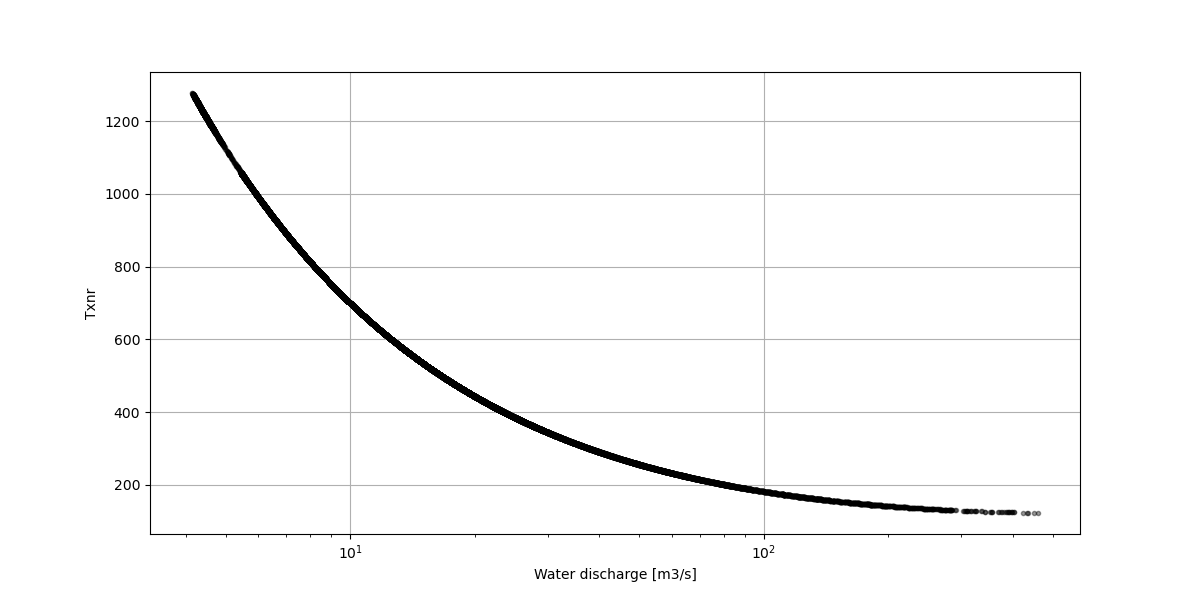

In [18]:
%matplotlib widget
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['smoothed Q [m3/s]'], df_hydro['Txnr [h]'], 'k.', alpha=0.4)
#ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Txnr')
ax1.set_xlabel('Water discharge [m3/s]')
plt.grid('on')

## Estimate Txnr for floods

### Detect floods

All periods in red are considered floods where sediment transport occurs. The critical discharge Qc is 30 m3/s.

In [19]:
# Initialize variables
flood_id = 0
flood_ids = []
# Critical discharge
Qc = 30# m3/s 

# Loop through each row
for i in range(len(df_hydro)):
    if df_hydro.loc[i, 'smoothed Q [m3/s]'] > Qc:
        # Start a new flood_id if it's the first in a new block
        if i == 0 or df_hydro.loc[i - 1, 'smoothed Q [m3/s]'] <= Qc:
            flood_id += 1
        flood_ids.append(flood_id)
    else:
        flood_ids.append(0)  # Set to 0 when Q <= Qc

# Add the 'flood id' column to the DataFrame
df_hydro['flood id'] = flood_ids

In [20]:
# Set the threshold for rows in between
threshold = 0

# Get indices of rows where 'flood id' is greater than 0
flood_indices = df_hydro.index[df_hydro['flood id'] > 0].tolist()

# Iterate through each pair of consecutive flood indices
for i in range(len(flood_indices) - 1):
    first_index = flood_indices[i]
    second_index = flood_indices[i + 1]
    
    # Count rows in between
    rows_between = second_index - first_index - 1
    
    # Check if the rows between are below the threshold
    if rows_between < threshold:
        # Update the second 'flood id' to match the first
        df_hydro.at[second_index, 'flood id'] = df_hydro.at[first_index, 'flood id']

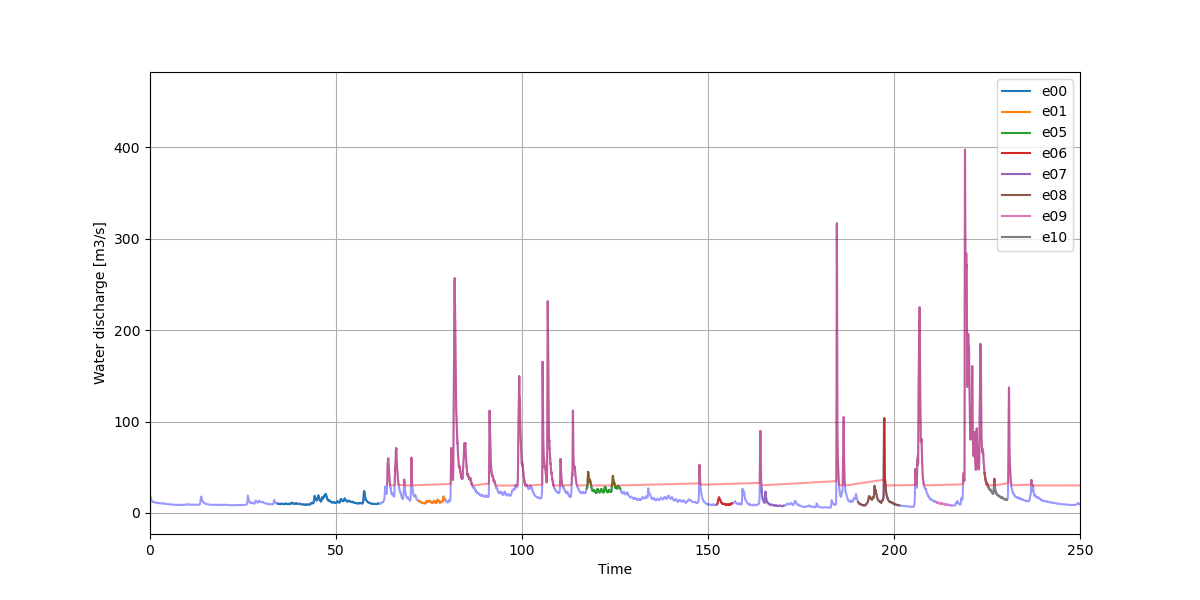

In [21]:
%matplotlib widget
Q_floods = df_hydro.loc[df_hydro['flood id'] > 0, 'smoothed Q [m3/s]']
date_floods = df_hydro.loc[df_hydro['flood id'] > 0, 't [days]']
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['t [days]'], df_hydro['smoothed Q [m3/s]'], 'b-', alpha=0.4)
for i in range(len(Q_surveys)):
    ax1.plot(time_surveys[i], Q_surveys[i], label= survey_names[i])
ax1.legend()
ax1.set_ylabel('Water discharge [m3/s]')
ax1.set_xlabel('Time')
ax1.set_xlim(0,250) 
ax1.plot(date_floods, Q_floods, 'r-', alpha=0.4)
plt.grid('on')

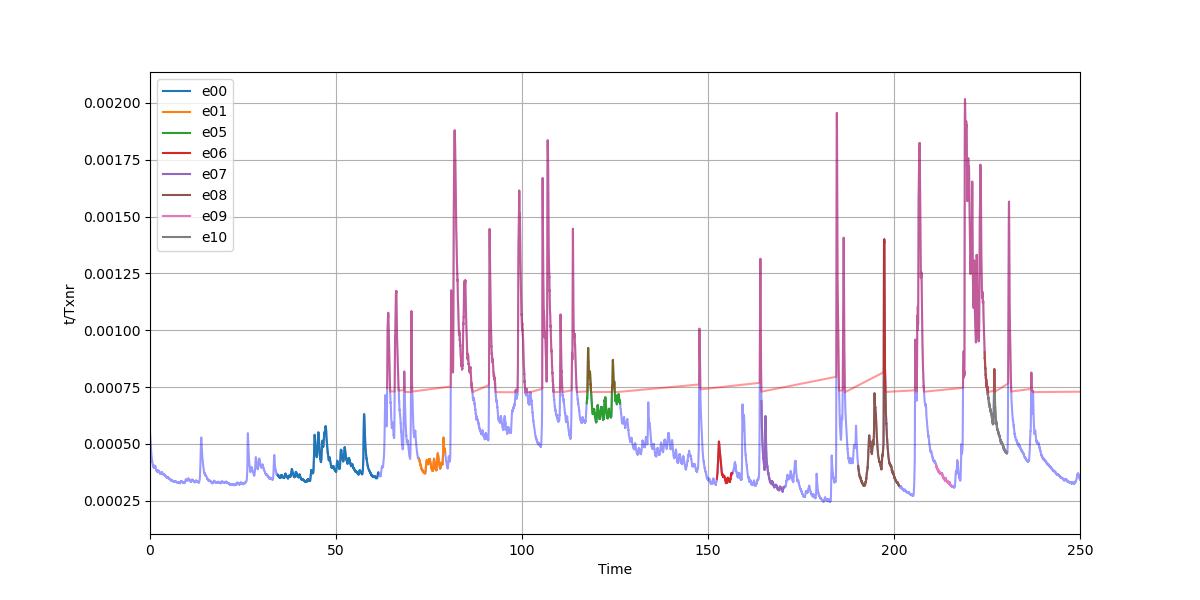

In [22]:
%matplotlib widget
t_Txnr_floods = df_hydro.loc[df_hydro['flood id'] > 0, 't_Txnr']
date_floods = df_hydro.loc[df_hydro['flood id'] > 0, 't [days]']
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['t [days]'], df_hydro['t_Txnr'], 'b-', alpha=0.4)
for i in range(len(Q_surveys)):
    ax1.plot(time_surveys[i], t_Txnr_surveys[i], label= survey_names[i])
ax1.legend()
ax1.set_ylabel('t/Txnr')
ax1.set_xlabel('Time')
ax1.set_xlim(0,250)
ax1.plot(date_floods, t_Txnr_floods, 'r-', alpha=0.4)
plt.grid('on')

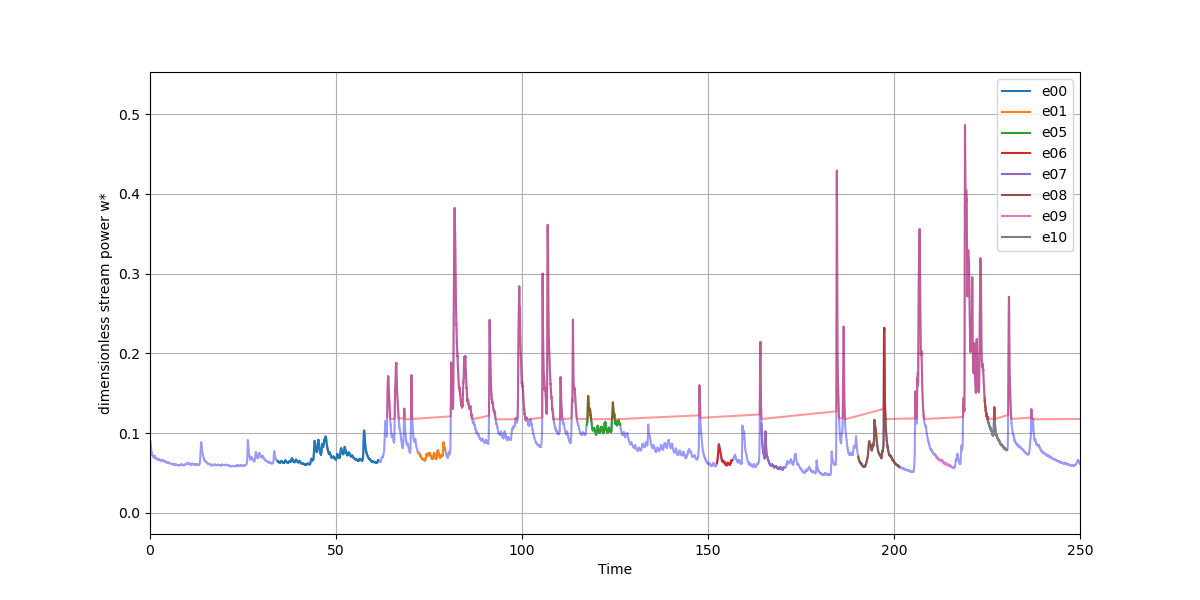

In [23]:
%matplotlib widget
adim_stream_floods = df_hydro.loc[df_hydro['flood id'] > 0, 'w*']
date_floods = df_hydro.loc[df_hydro['flood id'] > 0, 't [days]']
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['t [days]'], df_hydro['w*'], 'b-', alpha=0.4)
for i in range(len(Q_surveys)):
    ax1.plot(time_surveys[i], adim_stream_power_surveys[i], label= survey_names[i])
ax1.legend()
ax1.set_ylabel('dimensionless stream power w*')
ax1.set_xlabel('Time')
ax1.set_xlim(0,250)
ax1.plot(date_floods, adim_stream_floods, 'r-', alpha=0.4)
plt.grid('on')

### Compute flood statistics

In [24]:
flood_stats = (
    df_hydro[df_hydro['flood id'] > 0]
    .groupby('flood id')
    .agg(t_Txnr_sum=('t_Txnr', 'sum'), max_Q=('smoothed Q [m3/s]', 'max'), mean_Q=('smoothed Q [m3/s]', 'mean'), duration_days=('t [min]', lambda x: (x.max() - x.min())*60 / 86400))
    .reset_index()
)
flood_stats

,flood id,t_Txnr_sum,max_Q,mean_Q,duration_days
0,1,0.073455,59.85000,46.370886,0.812500
1,2,0.102086,70.70000,49.013785,1.104167
2,3,0.015461,36.57500,33.286250,0.197917
3,4,0.028625,60.62500,43.471875,0.322917
4,5,0.596015,256.87500,68.222040,5.812500
...,...,...,...,...,...
70,71,0.019920,36.70938,32.784306,0.260417
71,72,0.036770,51.80500,39.887234,0.437500
72,73,0.006757,32.74190,31.672363,0.083333
73,74,0.032247,74.22505,51.281574,0.333333


In [25]:
# Filter out flood less than 1 days ( they are no flood)
flood_stats['flood id'] = flood_stats['flood id'].where(flood_stats['duration_days']>1, 0)
flood_stats = flood_stats[flood_stats['flood id']>0]

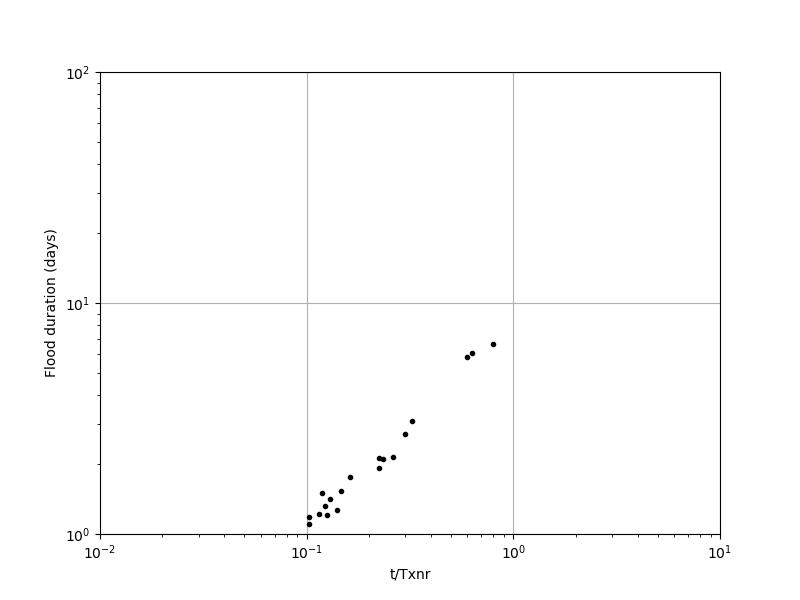

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(flood_stats['t_Txnr_sum'], flood_stats['duration_days'], 'k.')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.01,10)
ax1.set_ylim(1,100)
ax1.set_ylabel('Flood duration (days)')
ax1.set_xlabel('t/Txnr')
plt.grid('on')

## Surveys statistics

Survey time periods are unpaired numbers. Pair numbers are time periods between two surveys. Each variables is computed where Q > Qc.

In [30]:
# Filter out Q<Qc
df_hydro_Qc = df_hydro.copy()
condition = df_hydro_Qc['smoothed Q [m3/s]'] < Qc
columns_to_update = ['smoothed Q [m3/s]', 't_Txnr', 'Ww [m]']
df_hydro_Qc.loc[condition, columns_to_update] = 0
columns_to_update = ['w*']
df_hydro_Qc.loc[condition, columns_to_update] = np.nan # so that the mean is not affected by 0

In [31]:
df_txnr_surveys = df_hydro_Qc.groupby('surveys_id').agg(Q_max= ('smoothed Q [m3/s]','max'), t_txnr_sum=('t_Txnr', 'sum'),
    Ww_max=('Ww [m]', 'max'), w_mean=('w*','mean')).reset_index()

In [32]:
df_txnr_surveys

,surveys_id,Q_max,t_txnr_sum,Ww_max,w_mean
0,0,0.00000,0.000000,0.000000,NaN
1,1,0.00000,0.000000,0.000000,NaN
2,2,70.70000,0.219626,190.961165,0.147486
3,3,0.00000,0.000000,0.000000,NaN
4,4,256.87500,1.525155,341.256669,0.169314
5,5,44.99681,0.130342,155.825345,0.128252
6,6,52.77279,0.028290,167.413642,0.141111
7,7,0.00000,0.000000,0.000000,NaN
8,8,89.80363,0.044031,212.661352,0.164481
9,9,0.00000,0.000000,0.000000,NaN


## Compute variables for each DoDs

In [36]:
# Initialize empty lists to store results
t_txnr_sum_results = []
Ww_max_results = []
adim_stream_power = []
start_indices = []

# Define the window size and the overlap step
window_size = 3
step = 2

# Loop through the DataFrame with the specified window and step
i = 1  # Start at row index 1 (second row)
while i < len(df_txnr_surveys):
    # Define the window of 3 rows
    window_df = df_txnr_surveys.iloc[i:i + window_size]
    
    # Calculate the sum of 't_txnr_sum' and max of 'Ww_max' within the window
    t_txnr_sum_results.append(window_df['t_txnr_sum'].sum())
    Ww_max_results.append(window_df['Ww_max'].max())
    adim_stream_power.append(window_df['w_mean'].mean())
    
    # Keep track of the start index for each window for reference (optional)
    start_indices.append(i)
    
    # Move to the next block, start of the previous block + step
    i += step

# Create a DataFrame to store results with reference start indices
df_txnr_DoDs = pd.DataFrame({
    'start_index': start_indices,
    't_txnr_sum': t_txnr_sum_results,
    'Ww_max': Ww_max_results,
    'w*': adim_stream_power,
})

df_txnr_DoDs = df_txnr_DoDs.iloc[:-1] # exclude last row
# compute and add at the end of the dataframe two rows for the envDoD (both the sum of surveys and for the e10-e00DoD
total_sum_t_txnr = df_txnr_DoDs['t_txnr_sum'].sum()
max_wetted_width = df_txnr_DoDs['Ww_max'].max()
mean_stream_power = df_txnr_DoDs['w*'].mean()
new_row = {'start_index': 15, 't_txnr_sum': total_sum_t_txnr, 'Ww_max': max_wetted_width, 'w*':mean_stream_power}
df_txnr_DoDs.loc[len(df_txnr_DoDs)] = new_row
df_txnr_DoDs.loc[len(df_txnr_DoDs)+1] = new_row

# Add a column to identify dods
DoD_names = ['e01-e00','e05-e01','e06-e05','e07-e06','e08-e07','e09-e08','e10-e09','e10-e00_envDoD','e10-e00_DoD']
df_txnr_DoDs.insert(1, 'DoD_name', DoD_names)

In [37]:
df_txnr_DoDs 

,start_index,DoD_name,t_txnr_sum,Ww_max,w*
0,1,e01-e00,0.219626,190.961165,0.147486
1,3,e05-e01,1.655497,341.256669,0.148783
2,5,e06-e05,0.158632,167.413642,0.134682
3,7,e07-e06,0.044031,212.661352,0.164481
4,9,e08-e07,0.191746,375.071716,0.181026
5,11,e09-e08,0.299457,321.602148,0.181605
6,13,e10-e09,0.815863,415.297334,0.177309
7,15,e10-e00_envDoD,3.384851,415.297334,0.162196
9,15,e10-e00_DoD,3.384851,415.297334,0.162196


# Morphological active width
---

All DEMs/DoDs does not have the same extent:
* the upstream part of DEM e06 is much narrower than the other DEMs
* DEMs e00, e01, e05, e08, and e10 are more or less similar.

## Compute DoD envelops

In [38]:
DoD_names = ['e01-e00','e05-e01','e06-e05','e07-e06','e08-e07','e09-e08','e10-E09']
# first I simply compute the total envelop (sum of absolute values)
envDoD = None
mask_nan_tot = None
for i, DoD_name in enumerate(DoD_names):
    if DoD_name == 'e10-E09':
        path = os.path.join(home_folder,'Data',f'DoDs_{DoD_name}_Merge')
    else:
        path = os.path.join(home_folder,'Data',f'DoDs_{DoD_name}')
    filename = 'thresh.tif'
    DoD = read_tif(os.path.join(path,filename))
    mask_nan = np.where(DoD==-9999,0,1)
    valid_mask = DoD != -9999
    abs_DoD = np.abs(DoD)
    abs_DoD[~valid_mask] = 0
    if envDoD is None:
            envDoD = np.zeros_like(abs_DoD)
            mask_nan_tot = np.zeros_like(abs_DoD)
    envDoD += abs_DoD
    mask_nan_tot += mask_nan
    
output_path = os.path.join(home_folder,'Data','envDoDs')
envDoD = np.where(mask_nan_tot==0,-9999,mask_nan*0+1)
if not(os.path.exists(output_path)):
    os.makedirs(output_path)
    
outfile = 'thresh.tif'# f'{DoD_names[0][4:]}-{DoD_names[-1][:3]}_envDoDs.tif'
# save in tiff format
numpy_array_to_raster(os.path.join(output_path,outfile),
                          envDoD,
                          (1235580.0000000000000000,5032570.0000000000000000),
                          0.5,  # Resolution in x-direction
                          0.5,  # Resolution in y-direction
                          no_data=-9999,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=2193,  # Default to WGS84
                          driver='GTiff')

Array Shape: Rows = 4780, Columns = 3400, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Rees\Data\envDoDs\thresh.tif


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000021035C5F600> >

## Compute morphological active width

The morphological active width is calculated on a mask corresponding to the area of the e09 DEM.

The morphological active width is computed as follow:
$$
\frac{Area\; of\; morphological\; changes}{Reach\; length\; *\; Max\; wetted\; width}
$$

In [39]:
DoD_names = ['e01-e00','e05-e01','e06-e05','e07-e06','e08-e07','e09-e08','e10-E09_Merge','envDoDs', 'e10-e00']
reach_length = 1922 # m
wetted_width = df_txnr_DoDs.loc[:, 'Ww_max'].tolist()
# Import e09 to create the mask of analysis

path_mask = os.path.join(home_folder,'Data', 'DEMs', 'e09_clean', 'e09_clean_dem.tif')
mask = read_tif(os.path.join(path_mask))
e09_mask = np.where(mask > 0, 1, 0)

MAW_list = []
for i, DoD_name in enumerate(DoD_names):
    if DoD_name == 'envDoDs':
        path = os.path.join(home_folder,'Data',DoD_name)
        filename = 'e00-e10_envDoDs.tif'
    else:
        path = os.path.join(home_folder,'Data',f'DoDs_{DoD_name}')
        filename = 'thresh.tif'
        
    Total_area = reach_length * wetted_width[i]
    
    DoD = read_tif(os.path.join(path,filename))
    valid_mask = DoD != -9999 
    abs_DoD = np.abs(DoD)
    abs_DoD[~valid_mask] = 0
    abs_DoD = np.where(e09_mask ==1, abs_DoD, 0)
    mask_MC = np.where(abs_DoD>0, 1, 0)
    MC_area = len(mask_MC[mask_MC==1])
    MAW = (MC_area*0.25)/Total_area*100
    MAW_list = np.append(MAW_list, MAW)
#MAW_list = MAW_list[:-1]
df_txnr_DoDs['MAW (%)'] = MAW_list

The total corridor area is 367027.3596364198 m2
The total corridor area is 655895.3181702627 m2
The total corridor area is 321769.0201852873 m2
The total corridor area is 408735.1191632688 m2
The total corridor area is 720887.8383245511 m2
The total corridor area is 618119.328836573 m2
The total corridor area is 798201.4763478222 m2
The total corridor area is 798201.4763478222 m2
The total corridor area is 798201.4763478222 m2


In [40]:
df_txnr_DoDs

,start_index,DoD_name,t_txnr_sum,Ww_max,w*,MAW (%)
0,1,e01-e00,0.219626,190.961165,0.147486,40.787286
1,3,e05-e01,1.655497,341.256669,0.148783,51.495603
2,5,e06-e05,0.158632,167.413642,0.134682,19.139428
3,7,e07-e06,0.044031,212.661352,0.164481,18.010319
4,9,e08-e07,0.191746,375.071716,0.181026,26.900995
5,11,e09-e08,0.299457,321.602148,0.181605,37.216196
6,13,e10-e09,0.815863,415.297334,0.177309,48.594122
7,15,e10-e00_envDoD,3.384851,415.297334,0.162196,76.452345
9,15,e10-e00_DoD,3.384851,415.297334,0.162196,56.450503


# MAW-Txnr-w* relationship
---

In [41]:
# Get the data
MAW_rees = df_txnr_DoDs['MAW (%)'].to_numpy()[:-1]
t_Txnr_rees = df_txnr_DoDs['t_txnr_sum'].to_numpy()[:-1]
adim_stream_rees = df_txnr_DoDs['w*'].to_numpy()[:-1]
labels_rees = df_txnr_DoDs['DoD_name'].to_numpy()[:-1]

# Sunwapta data
MAW_Sunwapta = [21.8,21.76,40.5]#[0,0,1.18,2.54,3.89,21.8,21.76,4.62,1.58,0,40.5]
t_Txnr_Sunwapta = [0.31,0.41,2.43] #[0.05,0.24,0.3,0.26,0.26,0.31,0.41,0.26,0.15,0.21,2.43]
adim_stream_Sunwapta = [0.057,0.057,0.057]#,0.057,0.057,0.057,0.057,0.057,0.057,0.057,0.057]

# Lab data
MAW_PiQs = [23.6, 36.65, 43.03, 51.65, 69.6, 25.3, 37.075, 44.5, 49.8, 68.2, 36.3, 51.925, 59.6, 64.7, 75, 49.2, 66.05, 74.3, 79.5, 91.1 ]
t_Txnr_PiQs= [0.8, 1.6, 2.4, 3.2, 7.2, 0.5, 1, 1.5, 2, 4.5,0.4, 0.8, 1.2, 1.6, 3.6 ,0.5, 1, 1.5, 2, 4.5]
adim_stream_PiQs = [0.07,0.07,0.07,0.07,0.07, 0.11,0.11,0.11,0.11,0.11, 0.14,0.14,0.14,0.14,0.14, 0.25, 0.25, 0.25, 0.25, 0.25]


In [42]:
def power_law_regression(X, Y):
    """
    Fits a power-law relationship (Y = a * X^b) between two series of values using linear regression
    on the log-transformed data, handling NaN values and ensuring the output has the same length as the input.
    
    Parameters:
    X (list or numpy array): Independent variable data
    Y (list or numpy array): Dependent variable data
    
    Returns:
    a (float): Coefficient of the power law
    b (float): Exponent of the power law
    Y_pred (numpy array): Predicted Y values based on the power law relationship,
                          with NaN values at the same positions as in the original input.
    """
    
    # Convert inputs to numpy arrays (if they aren't already)
    X = np.array(X)
    Y = np.array(Y)
    
    # Create a mask to filter out NaN values from both X and Y
    valid_mask = ~np.isnan(X) & ~np.isnan(Y)
    
    # Filter out NaN values
    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    
    if len(X_valid) == 0 or len(Y_valid) == 0:
        raise ValueError("No valid data points after removing NaNs.")
    # Take the logarithm of X and Y
    log_X = np.log(X_valid)
    log_Y = np.log(Y_valid)
    
    # Perform linear regression on the log-transformed data
    mean_log_X = np.mean(log_X)
    mean_log_Y = np.mean(log_Y)
    
    # Calculate the slope (b)
    b = np.sum((log_X - mean_log_X) * (log_Y - mean_log_Y)) / np.sum((log_X - mean_log_X) ** 2)
    
    # Calculate the intercept (log(a))
    log_a = mean_log_Y - b * mean_log_X
    
    # Convert log(a) back to a
    a = np.exp(log_a)
    
    # Initialize Y_pred with NaN values and fill in the predictions for valid indices
    Y_pred = np.full_like(X, np.nan)  # Create an array of NaNs with the same shape as X
    Y_pred[valid_mask] = a * X_valid ** b  # Apply the power law relationship to the valid data points
    
    return a, b, Y_pred

In [43]:
# Compute empirical MAW-t_TXnr relationship in function of dimensionless stream power 
x_plot = [0,0.01,0.02,0.05,0.07,0.08,0.1,0.2,0.3,0.4,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5]
a_list = []
b_list = []
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[0:5], MAW_PiQs[0:5]) #q05
a_list.append(a)
b_list.append(b)
PiQs_MAW_q05_pred =  [a*x**b for x in x_plot]
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[5:10], MAW_PiQs[5:10]) #q07
a_list.append(a)
b_list.append(b)
PiQs_MAW_q07_pred = [a*x**b for x in x_plot]
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[10:15], MAW_PiQs[10:15]) #q10
a_list.append(a)
b_list.append(b)
PiQs_MAW_q10_pred = [a*x**b for x in x_plot]
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[15:20], MAW_PiQs[15:20]) #q20
a_list.append(a)
b_list.append(b)
PiQs_MAW_q20_pred = [a*x**b for x in x_plot]
print(a,b)

63.46018011632202 0.277589165299307


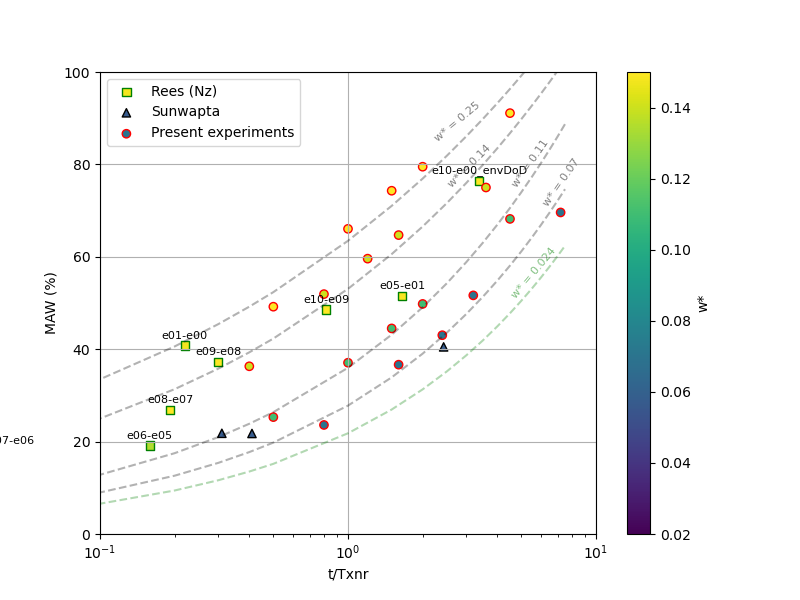

In [44]:
%matplotlib widget
from matplotlib.colors import Normalize
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
# colors
# Step 1: Combine z-values to find global min and max
all_colors = np.concatenate([adim_stream_PiQs, adim_stream_Sunwapta, adim_stream_rees])
color_min, color_max = all_colors.min(), all_colors.max()
# Step 2: Normalize z-values using the global min and max
norm = Normalize(vmin=0.02, vmax=0.15)
cmap='viridis'

ax1.scatter(t_Txnr_rees, MAW_rees, marker='s', edgecolors='g', linewidth=1, c=norm(adim_stream_rees), cmap=cmap,  vmin=0, vmax=1,label='Rees (Nz)')
ax1.scatter(t_Txnr_Sunwapta, MAW_Sunwapta  , marker='^', edgecolors='k', linewidth=1, c=norm(adim_stream_Sunwapta),alpha=1, cmap=cmap, vmin=0, vmax=1,label='Sunwapta')
ax1.scatter(t_Txnr_PiQs, MAW_PiQs, marker='o', edgecolors='r', linewidth=1, c=norm(adim_stream_PiQs), cmap=cmap,  vmin=0, vmax=1,alpha= 1, label='Present experiments')

ax1.plot(x_plot, PiQs_MAW_q05_pred, 'k--', alpha=0.3)
ax1.plot(x_plot, PiQs_MAW_q07_pred, 'k--', alpha=0.3)
ax1.plot(x_plot, PiQs_MAW_q10_pred, 'k--', alpha=0.3)
ax1.plot(x_plot, PiQs_MAW_q20_pred, 'k--', alpha=0.3)

for i, label in enumerate(labels_rees):
    ax1.text(t_Txnr_rees[i], MAW_rees[i] + 1, label, ha='center', va='bottom', fontsize=8)
    
# predict the MAW-t/Txnr relationship for w*=0.02
a = 196*0.024+17.1
b = -1.18*0.024+0.55
PiQs_MAW_w002_pred = [a*x**b for x in x_plot]
ax1.plot(x_plot, PiQs_MAW_w002_pred, 'g--', alpha=0.3)

# Add text to the plot
ax1.text(2.2, 85, 'w* = 0.25', fontsize=8, color='gray', rotation=40)
ax1.text(2.5, 75, 'w* = 0.14', fontsize=8, color='gray', rotation=45)
ax1.text(4.5, 75, 'w* = 0.11', fontsize=8, color='gray', rotation=55)
ax1.text(6, 71, 'w* = 0.07', fontsize=8, color='gray', rotation=55)
ax1.text(4.5, 51, 'w* = 0.024', fontsize=8, color='g',alpha=0.5, rotation=50)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax1, label='w*')
ax1.set_ylim(0,100)
ax1.set_xlim(0.1,10)
ax1.set_xscale('log')
ax1.set_xlabel('t/Txnr')
ax1.set_ylabel('MAW (%)')
ax1.legend(loc='upper left')
plt.grid('on')